In [19]:
# 1. Import Libraries
!pip install bertopic -qq

In [20]:
import os
import random
import re
import time
from collections import defaultdict
from tqdm.notebook import tqdm

import warnings
from pathlib import Path
from tqdm import tqdm
from typing import Any, Dict, List, Optional
from IPython.display import display, HTML

import pandas as pd 
import numpy as np
import scipy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import torch
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import BaseCrossValidator, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import log_loss
from sklearn.tree import plot_tree
from sentence_transformers import SentenceTransformer
from matplotlib import patches
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from lightgbm import LGBMClassifier
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Configuration
warnings.simplefilter("ignore")
sns.set_style("darkgrid")
pd.options.display.max_rows = None
pd.options.display.max_columns = None
colors = sns.color_palette("pastel")

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 2. Load train data

In [22]:
df_train = pd.read_parquet(
    '/kaggle/input/wsdm-cup-multilingual-chatbot-arena/train.parquet'
)
print(f"数据集共有 {len(df_train)} 行")
df_test = pd.read_parquet(
    '/kaggle/input/wsdm-cup-multilingual-chatbot-arena/test.parquet'
)
print("The First 5 Training Rows:")
display(df_train.head())
print("The 3 Test Rows:")
display(df_test.head())

数据集共有 48439 行
The First 5 Training Rows:


,id,prompt,response_a,response_b,winner,model_a,model_b,language
0,00007cff95d7f7974642a785aca248b0f26e60d3312fac...,vieš po Slovensky?,"Áno, hovorím po slovensky. Ako vám môžem pomôcť?","Áno, veď som tu! Môžem ti pomôcť s otázkami al...",model_a,o1-preview,reka-core-20240904,Slovak
1,00010ed04b536f56ebe43eef1100c13906abea12bf9855...,You will be given a piece of news. Analyze it ...,Let's break down the news and analyze it accor...,"```json\n{\n ""contains_orgs"": true,\n ""orgs""...",model_a,gemma-2-27b-it,gemini-1.5-flash-002,Russian
2,0003800d510e38803efba5ceaec122bc66408fe367b0be...,"Dört basamaklı, rakamları birbirinden ve sıfır...","Bu soruyu çözmek için, verilen koşulları adım ...",Bu problemi adım adım çözelim:\n\n1) ABCD - DC...,model_a,gpt-4-0125-preview,claude-3-5-sonnet-20240620,Turkish
3,00072026c68f5418ef2da238394e418ce72a534b9b22d5...,"현재 추천된 탑 3 종목인 Cabaletta Bio (CABA), Rocket Ph...","죄송하지만 저는 금융 조언을 제공할 수 없습니다. 저는 AI 모델이며, 투자 결정에...",현재 추천된 탑 3 종목에 순위를 매기기 위해서는 여러 가지 요소들을 고려해야 합니...,model_b,gemma-2-2b-it,llama-3.1-nemotron-70b-instruct,English
4,0007ce7cf6bc1b5a8f8a4669b854fb12030863c970d9dc...,Please be boring,"Alright, I'll be as boring as possible.\n\nTod...","Understood. Here is a straightforward, unadorn...",model_a,reka-flash-20240722,grok-2-2024-08-13,English


The 3 Test Rows:


,id,prompt,response_a,response_b,scored
0,327228,Caso Clínico: Un hombre de 70 años con anteced...,**Diagnóstico Diferencial de Anemia en Pacient...,"Basándonos en el caso clínico presentado, pode...",False
1,1139415,Peel Company received a cash dividend from a ...,The correct answer is **(a) No No**. Here's ...,The correct answer is **(a) No No**. Here's wh...,False
2,1235630,Há um grave problema com o relógio da torre da...,Dois problemas interessantes!\n\n**Problema 1:...,Vamos resolver os dois problemas em sequência....,False


In [23]:

df_train_1 = pd.read_parquet(
    '/kaggle/input/llm-human-preference-data-ultrafeedback/ultrafeedback.parquet'
)
display(df_train_1.head(5))


,source,prompt,chosen,chosen-rating,chosen-model,rejected,rejected-rating,rejected-model
0,evol_instruct,Can you write a C++ program that prompts the u...,[{'content': 'Can you write a C++ program that...,5.00,starchat,[{'content': 'Can you write a C++ program that...,1.25,alpaca-7b
1,evol_instruct,Can you write a C++ program that prompts the u...,[{'content': 'Can you write a C++ program that...,5.00,starchat,[{'content': 'Can you write a C++ program that...,4.00,vicuna-33b
2,evol_instruct,Can you write a C++ program that prompts the u...,[{'content': 'Can you write a C++ program that...,5.00,starchat,[{'content': 'Can you write a C++ program that...,1.25,pythia-12b
3,evol_instruct,Suppose you are a content creator and want to ...,[{'content': 'Suppose you are a content creato...,4.75,gpt-4,[{'content': 'Suppose you are a content creato...,4.25,llama-2-13b-chat
4,evol_instruct,Suppose you are a content creator and want to ...,[{'content': 'Suppose you are a content creato...,4.75,gpt-4,[{'content': 'Suppose you are a content creato...,3.25,starchat


In [24]:
df_train_2 = pd.read_csv(
    '/kaggle/input/lmsys-chatbot-arena/train.csv'
)
print(f"数据集共有 {len(df_train_2)} 行")
display(df_train_2.head(5))


数据集共有 57477 行


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


In [25]:
import pandas as pd
import json

# 读取数据
test = pd.read_csv('/kaggle/input/lmsys-chatbot-arena/test.csv')

# 定义 JSON 解析函数
def process_text(text):
    return json.loads(text)

# 解析 JSON 格式的列
test.loc[:, 'prompt'] = test['prompt'].apply(process_text)
test.loc[:, 'response_a'] = test['response_a'].apply(process_text)
test.loc[:, 'response_b'] = test['response_b'].apply(process_text)

# 调整 Pandas 设置以显示完整列内容
#pd.set_option('display.max_colwidth', None)

# 显示 DataFrame
display(test.head())

,id,prompt,response_a,response_b
0,136060,"[I have three oranges today, I ate an orange y...",[You have two oranges today.],[You still have three oranges. Eating an orang...
1,211333,[You are a mediator in a heated political deba...,[Thank you for sharing the details of the situ...,[Mr Reddy and Ms Blue both have valid points i...
2,1233961,[How to initialize the classification head whe...,[When you want to initialize the classificatio...,[To initialize the classification head when pe...


                         chosen_interval  count  proportion  mean_score_diff  \
0                                1.0-1.4     33    0.000209         0.250000   
1                 1.4-1.7999999999999998    197    0.001249         0.459391   
2  1.7999999999999998-2.1999999999999997    231    0.001465         0.679654   
3  2.1999999999999997-2.5999999999999996    816    0.005175         0.819240   
4  2.5999999999999996-2.9999999999999996    684    0.004338         0.990497   
5  2.9999999999999996-3.3999999999999995   2602    0.016502         1.070715   
6  3.3999999999999995-3.7999999999999994   6112    0.038763         1.162713   
7   3.7999999999999994-4.199999999999999   6630    0.042049         1.291290   
8                  4.199999999999999-4.6  35778    0.226910         1.405459   
9                  4.6-4.999999999999999  43070    0.273157         1.360082   

   std_score_diff  negative_diff_ratio  
0        0.000000                  0.0  
1        0.196268                  0.

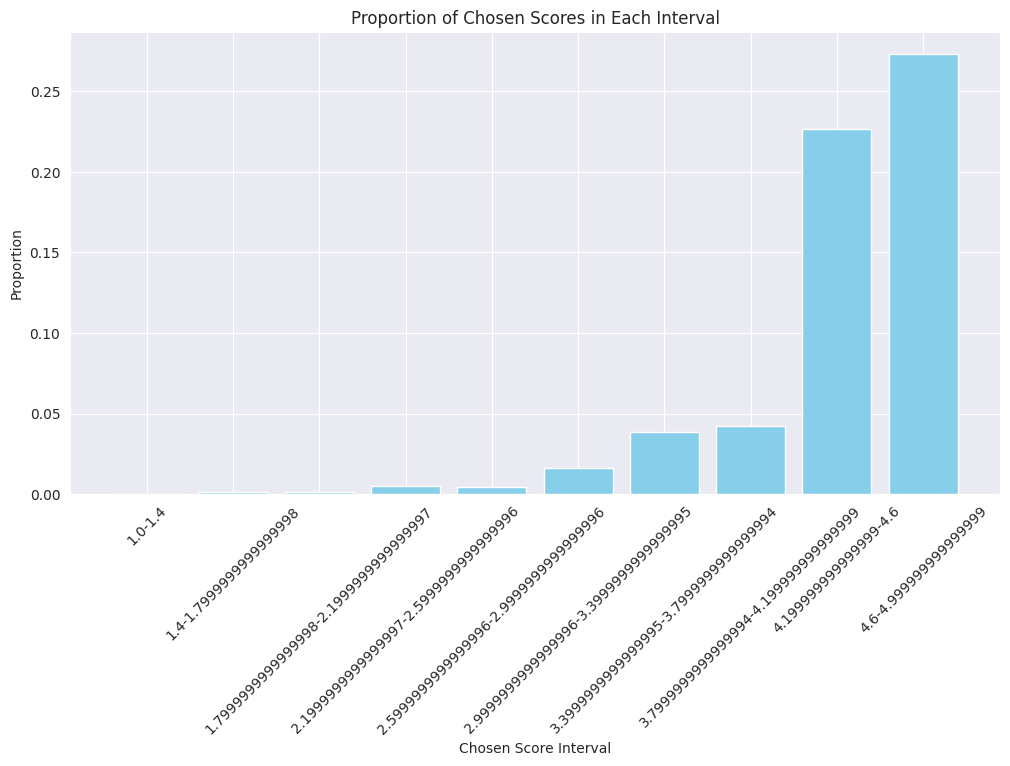

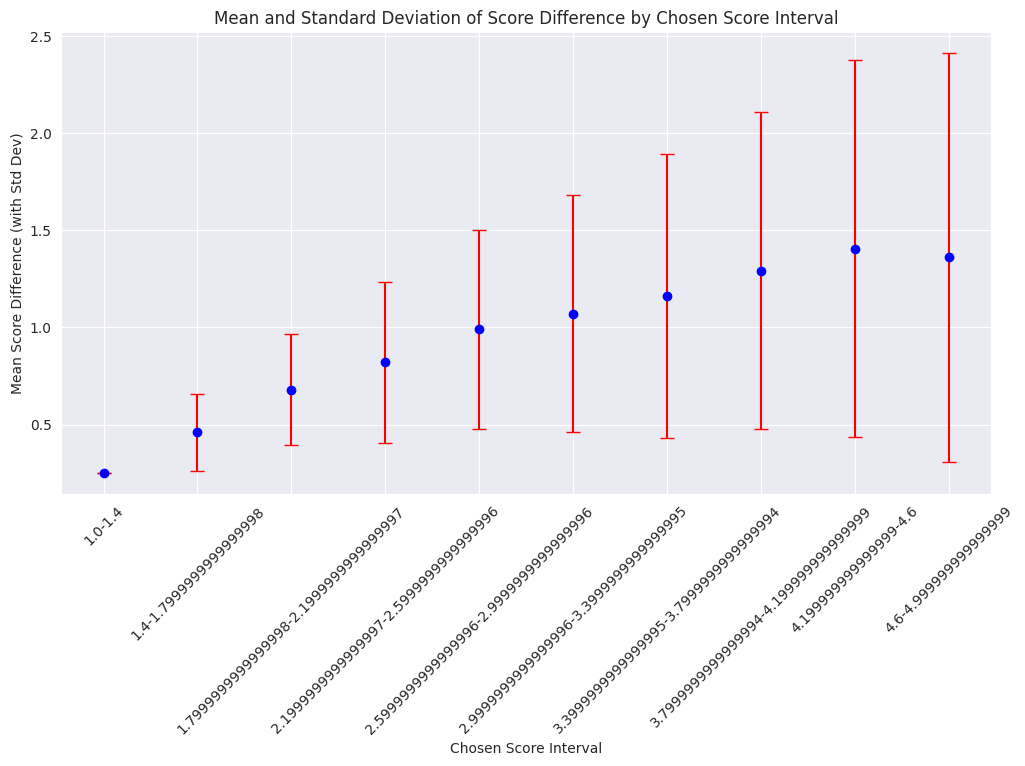

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取 parquet 文件
data = pd.read_parquet("/kaggle/input/llm-human-preference-data-ultrafeedback/ultrafeedback.parquet")

# 提取 chosen_score 和 rejected_score
chosen_scores = data['chosen-rating']
rejected_scores = data['rejected-rating']

# 计算 chosen_score - rejected_score 差值
data['score_diff'] = chosen_scores - rejected_scores

# 定义区间范围
bins = np.arange(1.0, chosen_scores.max() + 0.4, 0.4)  # 区间从 1.0 开始，以 0.4 为步长
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]  # 区间标签

# 按区间划分 chosen_score
data['chosen_interval'] = pd.cut(chosen_scores, bins=bins, labels=labels, right=False)

# 计算统计数据
interval_stats = data.groupby('chosen_interval').agg(
    count=('chosen-rating', 'count'),                      # 每个区间的数量
    proportion=('chosen-rating', lambda x: len(x) / len(data)),  # 每个区间的比例
    mean_score_diff=('score_diff', 'mean'),               # 差值均值
    std_score_diff=('score_diff', 'std'),                 # 差值标准差
    negative_diff_ratio=('score_diff', lambda x: np.mean(x < 0))  # 差值为负的比例
).reset_index()

# 打印区间统计数据
print(interval_stats)

# 可视化 chosen_score 的区间分布
plt.figure(figsize=(12, 6))
plt.bar(interval_stats['chosen_interval'], interval_stats['proportion'], color='skyblue')
plt.xlabel('Chosen Score Interval')
plt.ylabel('Proportion')
plt.title('Proportion of Chosen Scores in Each Interval')
plt.xticks(rotation=45)
plt.show()

# 可视化每个区间内 score_diff 的均值和标准差
plt.figure(figsize=(12, 6))
plt.errorbar(interval_stats['chosen_interval'], interval_stats['mean_score_diff'], 
             yerr=interval_stats['std_score_diff'], fmt='o', color='blue', ecolor='red', capsize=5)
plt.xlabel('Chosen Score Interval')
plt.ylabel('Mean Score Difference (with Std Dev)')
plt.title('Mean and Standard Deviation of Score Difference by Chosen Score Interval')
plt.xticks(rotation=45)
plt.show()

In [27]:
# 逐行打印前5行的内容
for i in range(3):
    print(f"\n--- Row {i} ---")
    print("Prompt:")
    print(df_train['prompt'].iloc[i])
    print("Response A:")
    print(df_train['response_a'].iloc[i])
    print("\nResponse B:")
    print(df_train['response_b'].iloc[i])
    print("\n" + "="*50)  # 分隔线


--- Row 0 ---
Prompt:
vieš po Slovensky?
Response A:
Áno, hovorím po slovensky. Ako vám môžem pomôcť?

Response B:
Áno, veď som tu! Môžem ti pomôcť s otázkami alebo problémami, ktoré máš. Ako ti môžem pomôcť dnes?

(Yes, I'm here! I can help you with questions or problems you have. How can I help you today?)


--- Row 1 ---
Prompt:
You will be given a piece of news. Analyze it according to the following algorithm. First, determine the main event descibed in the text. News often contain references to previously reported facts. 
    These references should be ignored. Second, determine whether any commercial or government organizations are discussed in the main topic. 
    For all found organizations determine sentiment of the organization activities considering the possible effect of these activities on the organization itself. 
    Ignore all organizations with neutral sentiment, I need only positive and negative sentiment. Ignore cases when organization provides analytics, I need onl

In [28]:
#输出表格形状
print(f"Data Shape | train {df_train.shape} | test {df_test.shape}")

Data Shape | train (48439, 8) | test (3, 5)


In [29]:
assert df_train["id"].nunique() == len(df_train)
print("唯一id数量:", df_train["id"].nunique())
print("总行数:", len(df_train))

唯一id数量: 48439
总行数: 48439


In [30]:
demo_chat = df_train.iloc[0]
for col in ["prompt", "response_a", "response_b"]:
    assert isinstance(demo_chat[col], str)
print(f"=== Prompt ===")
print(demo_chat["prompt"])
print()
print(f"=== Response of {demo_chat['model_a']} ===") 
print(demo_chat["response_a"])
print()
print(f"=== Response of {demo_chat['model_b']} ===") 
print(demo_chat["response_b"])
print("-" * 50)
if demo_chat["winner"]=="model_a":
    print(f">>> {demo_chat['model_a']} is the winner!!")
else:
    print(f">>> {demo_chat['model_b']} is the winner!!")


=== Prompt ===
vieš po Slovensky?

=== Response of o1-preview ===
Áno, hovorím po slovensky. Ako vám môžem pomôcť?

=== Response of reka-core-20240904 ===
Áno, veď som tu! Môžem ti pomôcť s otázkami alebo problémami, ktoré máš. Ako ti môžem pomôcť dnes?

(Yes, I'm here! I can help you with questions or problems you have. How can I help you today?)
--------------------------------------------------
>>> o1-preview is the winner!!


In [31]:
unknown_model_a = df_train["model_a"].isna().sum() + (df_train["model_a"] == "").sum()
unknown_model_b = df_train["model_b"].isna().sum() + (df_train["model_b"] == "").sum()
print(f"There exist {unknown_model_a} unknown model_a and {unknown_model_b} unknown model_b identities.")

There exist 0 unknown model_a and 0 unknown model_b identities.


# 3. Visualizations

Here are some visualization ideas to explore the data:

## a) Distribution of winners
This will show how often each model (A or B) was selected as the winner.

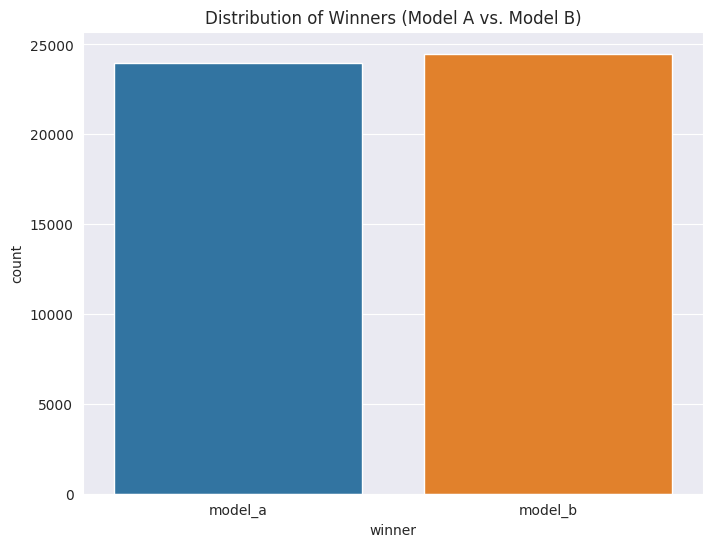

In [32]:
plt.figure(figsize=(8, 6))
sns.countplot(x='winner', data=df_train)
plt.title('Distribution of Winners (Model A vs. Model B)')
plt.show()

model_a
chatgpt-4o-latest-20240903         1863
gemini-1.5-pro-002                 1836
yi-lightning-lite                  1681
claude-3-opus-20240229             1665
qwen-max-0919                      1630
gemini-1.5-flash-8b-001            1436
llama-3.1-405b-instruct-bf16       1432
grok-2-2024-08-13                  1401
gemini-1.5-flash-002               1329
qwen-plus-0828                     1318
claude-3-5-sonnet-20240620         1255
internlm2_5-20b-chat               1215
gemma-2-2b-it                      1178
o1-mini                            1167
o1-preview                         1165
yi-lightning                       1131
llama-3.2-1b-instruct              1075
gemini-1.5-flash-8b-exp-0827       1047
command-r-08-2024                  1037
mistral-large-2407                 1020
command-r-plus-08-2024             1001
llama-3.2-3b-instruct               990
glm-4-plus                          939
qwen2.5-72b-instruct                919
grok-2-mini-2024-08-13          

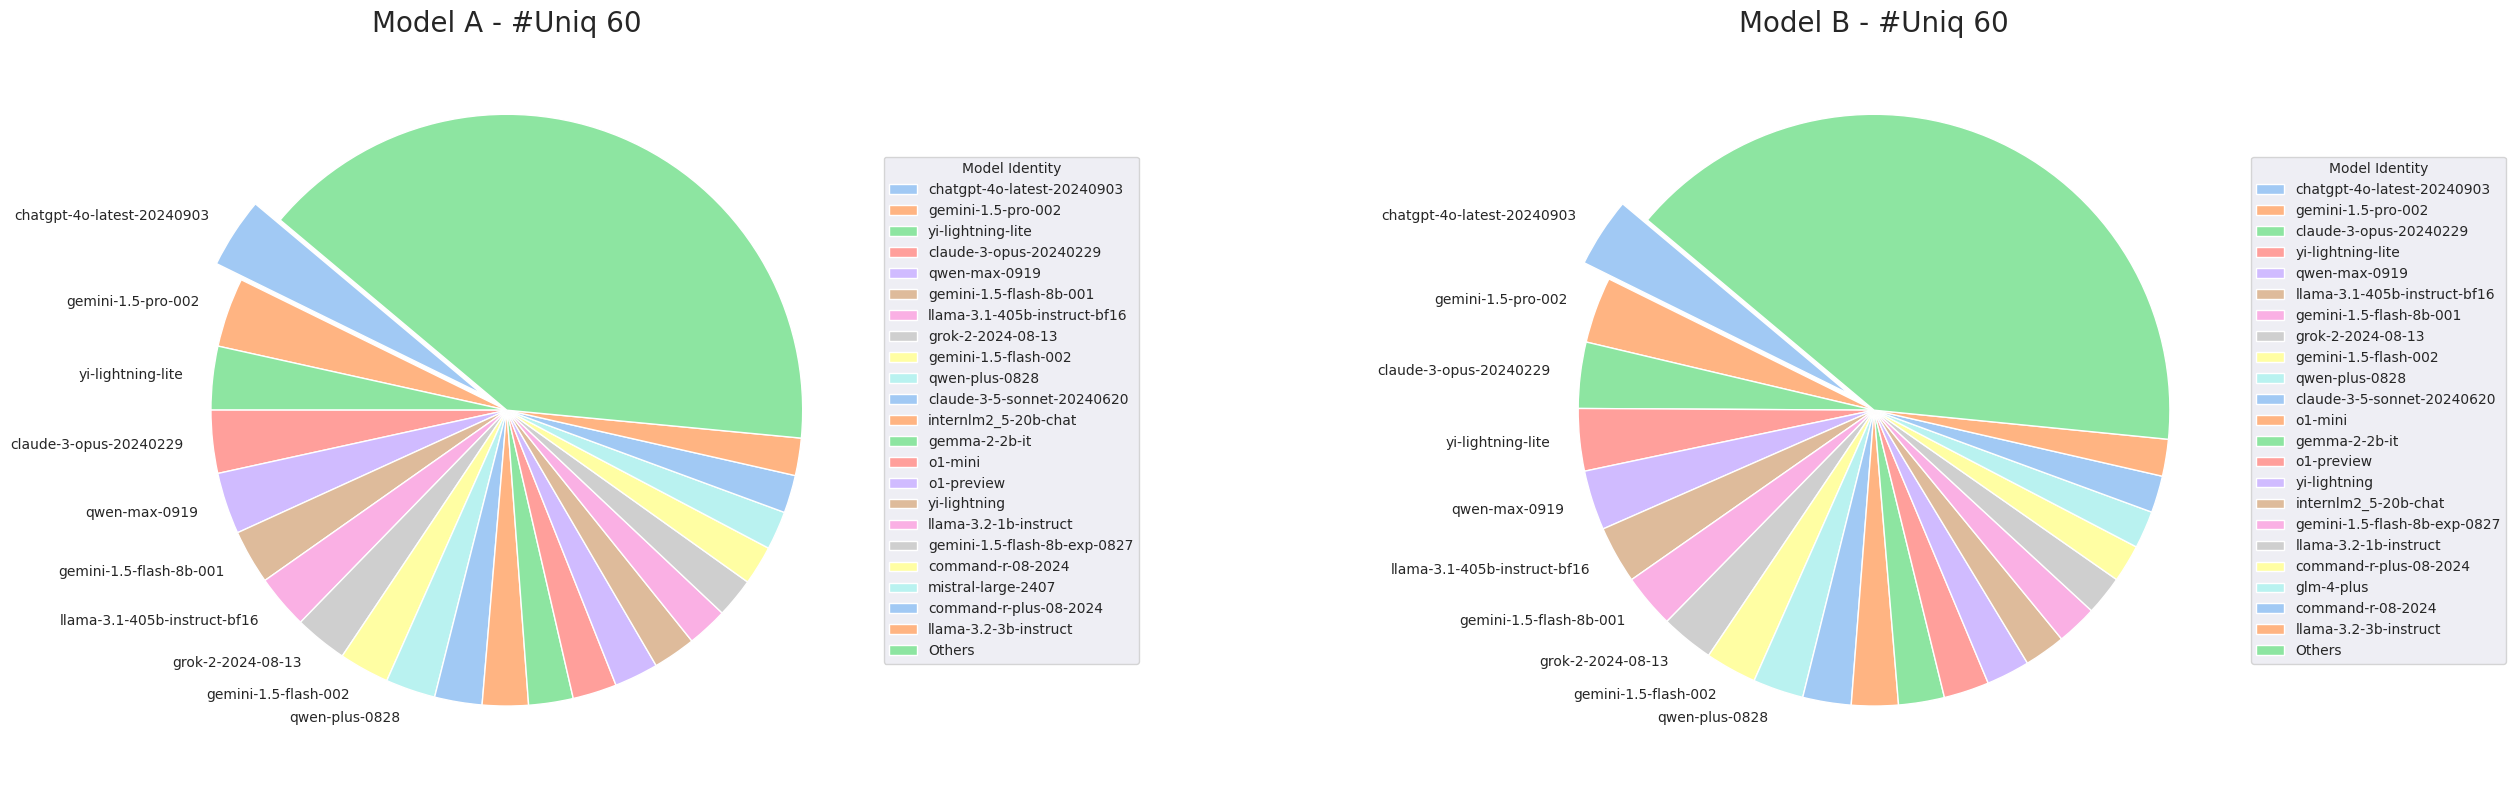

In [33]:
def _plot_pie(
    data: np.ndarray,
    labels: List[str], 
    title: str,
    combine_minority: bool = False,
    thres: float = 0.01, 
    max_labels: int = 10,
    ax: Optional[Axes] = None,
) -> None:
    tot = sum(data)
    max_idx = np.argmax(data)
    if combine_minority:
        major_data = [(d, l) for d, l in zip(data, labels) if d / tot >= thres]
        minor_data = [(d, l) for d, l in zip(data, labels) if d / tot < thres]
        
        if len(minor_data) != 0:
            # Add one "Others" class to store minority classes
            minor_tot = sum(d for d, l in minor_data)
            major_data.append((minor_tot, "Others"))
        
        data, labels = map(list, zip(*major_data))
        max_idx = np.argmax(data[:-1])
        
    # Sort data/labels
    # ...
    explode = [0.1 if i == max_idx else 0 for i in range(len(data))]    

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    if len(data) > max_labels:
        visible_labels = labels[:max_labels] + [""] * (len(data) - max_labels)
    else:
        visible_labels = labels
    patches, texts = ax.pie(data, startangle=140, colors=colors, explode=explode, labels=visible_labels)
    ax.legend(patches, labels, title="Model Identity", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title(title, fontsize=20)
    if ax is None:
        plt.show()

model_a_val_cnt = df_train["model_a"].value_counts()
print(model_a_val_cnt);
print("--------------------------------------------");
model_b_val_cnt = df_train["model_b"].value_counts()
print(model_b_val_cnt);
n_uniq_as, n_uniq_bs = len(model_a_val_cnt), len(model_b_val_cnt)
assert set(model_a_val_cnt.index) == set(model_b_val_cnt.index)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(28, 8))
_plot_pie(
    model_a_val_cnt.values,
    model_a_val_cnt.index.tolist(), 
    title=f"Model A - #Uniq {n_uniq_as}",
    combine_minority=True,
    thres=0.02,
    max_labels=10,
    ax=axes[0]
)
_plot_pie(
    model_b_val_cnt.values,
    model_b_val_cnt.index.tolist(), 
    title=f"Model B - #Uniq {n_uniq_bs}",
    combine_minority=True,
    thres=0.02,
    max_labels=10,
    ax=axes[1]
)
plt.tight_layout()

In [18]:
TARGETS = ["winner"]  # 新表格只有一个winner列，不是分成a和b

df_btl = (
    df_train.groupby(["model_a", "model_b"], as_index=False)
    .agg({
        "prompt": "count",  # 统计对战次数
        "winner": lambda x: (x == "model_a").sum()  # 计算model_a获胜次数
    })
    .rename({"prompt": "battle_cnt"}, axis=1)
    .sort_values("battle_cnt", ascending=False)
    .reset_index(drop=True)
)

# 计算胜率
df_btl["model_a_win_rate"] = df_btl["winner"] / df_btl["battle_cnt"]
df_btl["model_b_win_rate"] = 1 - df_btl["model_a_win_rate"]  # model_b的胜率是1减去model_a的胜率

# 显示结果
df_btl.head(20)

,model_a,model_b,battle_cnt,winner,model_a_win_rate,model_b_win_rate
0,claude-3-opus-20240229,chatgpt-4o-latest-20240903,104,30,0.288462,0.711538
1,chatgpt-4o-latest-20240903,claude-3-opus-20240229,102,68,0.666667,0.333333
2,qwen-plus-0828,chatgpt-4o-latest-20240903,100,20,0.200000,0.800000
3,gemini-1.5-flash-8b-001,yi-lightning,95,27,0.284211,0.715789
4,yi-lightning,yi-lightning-lite,94,58,0.617021,0.382979
5,chatgpt-4o-latest-20240903,gemini-1.5-pro-002,93,58,0.623656,0.376344
6,chatgpt-4o-latest-20240903,qwen-plus-0828,92,72,0.782609,0.217391
7,gemini-1.5-pro-002,chatgpt-4o-latest-20240903,91,37,0.406593,0.593407
8,yi-lightning-lite,yi-lightning,91,40,0.439560,0.560440
9,yi-lightning-lite,o1-mini,91,29,0.318681,0.681319


## b) Prompt length distribution
This will give an idea of the typical prompt lengths and their distribution.

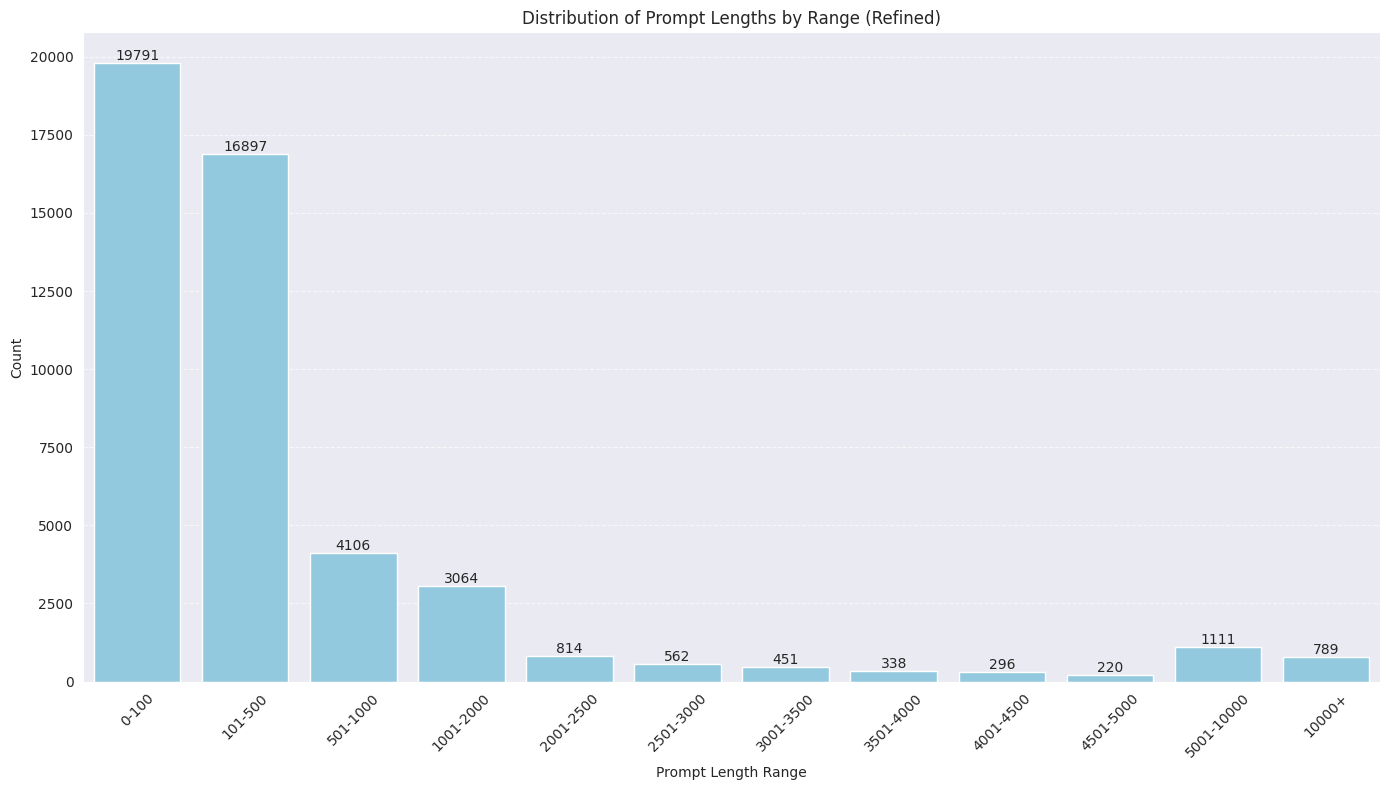


详细统计信息：
      长度区间    数量    占比
     0-100 19791 40.86
   101-500 16897 34.88
  501-1000  4106  8.48
 1001-2000  3064  6.33
 2001-2500   814  1.68
 2501-3000   562  1.16
 3001-3500   451  0.93
 3501-4000   338  0.70
 4001-4500   296  0.61
 4501-5000   220  0.45
5001-10000  1111  2.29
    10000+   789  1.63


In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 计算prompt长度
df_train['prompt_length'] = df_train['prompt'].apply(len)

# 创建更细致的区间范围
bins = [0, 100, 500, 1000, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000, float('inf')]
labels = [
    '0-100', '101-500', '501-1000', '1001-2000', 
    '2001-2500', '2501-3000', '3001-3500', '3501-4000', 
    '4001-4500', '4501-5000', '5001-10000', '10000+'
]

# 统计每个区间的数量
df_train['length_group'] = pd.cut(df_train['prompt_length'], bins=bins, labels=labels)
length_stats = df_train['length_group'].value_counts().sort_index()

# 创建图表
plt.figure(figsize=(14, 8))

# 绘制条形图
ax = sns.barplot(x=length_stats.index, y=length_stats.values, color='skyblue')

# 在柱子上添加具体数值
for i, v in enumerate(length_stats.values):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.title('Distribution of Prompt Lengths by Range (Refined)', fontsize=12)
plt.xlabel('Prompt Length Range', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# 显示图表
plt.tight_layout()
plt.show()

# 打印详细统计信息
print("\n详细统计信息：")
stats_df = pd.DataFrame({
    '长度区间': length_stats.index,
    '数量': length_stats.values,
    '占比': (length_stats.values / len(df_train) * 100).round(2)
})
print(stats_df.to_string(index=False))

## c) Response length distribution for each model
This compares the response lengths of models A and B.

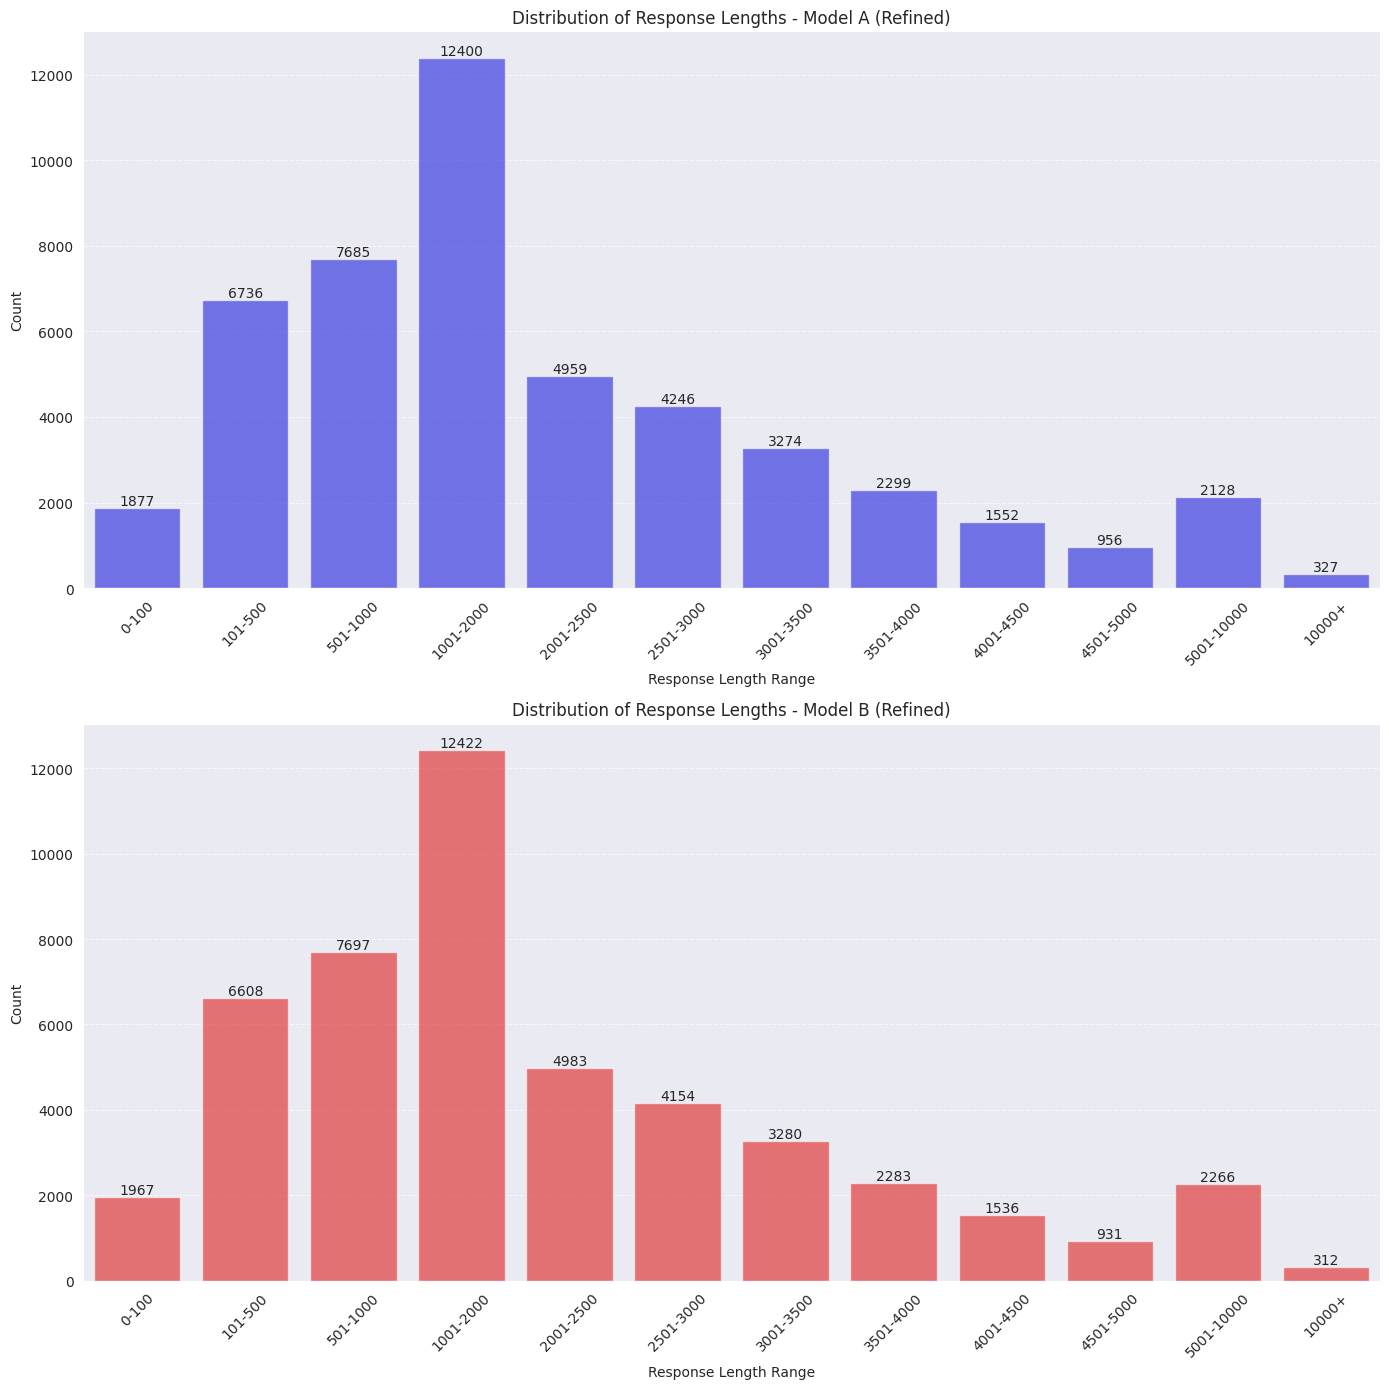


Model A 响应长度统计：
      长度区间    数量  占比(%)
     0-100  1877   3.87
   101-500  6736  13.91
  501-1000  7685  15.87
 1001-2000 12400  25.60
 2001-2500  4959  10.24
 2501-3000  4246   8.77
 3001-3500  3274   6.76
 3501-4000  2299   4.75
 4001-4500  1552   3.20
 4501-5000   956   1.97
5001-10000  2128   4.39
    10000+   327   0.68

Model B 响应长度统计：
      长度区间    数量  占比(%)
     0-100  1967   4.06
   101-500  6608  13.64
  501-1000  7697  15.89
 1001-2000 12422  25.64
 2001-2500  4983  10.29
 2501-3000  4154   8.58
 3001-3500  3280   6.77
 3501-4000  2283   4.71
 4001-4500  1536   3.17
 4501-5000   931   1.92
5001-10000  2266   4.68
    10000+   312   0.64

基本统计量：

Model A 响应长度：
count    48439.000000
mean      2015.563265
std       1917.223850
min          1.000000
25%        725.000000
50%       1599.000000
75%       2796.000000
max      57222.000000
Name: response_a_length, dtype: float64

Model B 响应长度：
count     48439.000000
mean       2020.373315
std        1957.196923
min           1.000

In [41]:
# 计算响应长度
df_train['response_a_length'] = df_train['response_a'].apply(len)
df_train['response_b_length'] = df_train['response_b'].apply(len)

# 定义更细致的长度区间
bins = [0, 100, 500, 1000, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000, float('inf')]
labels = [
    '0-100', '101-500', '501-1000', '1001-2000', 
    '2001-2500', '2501-3000', '3001-3500', '3501-4000', 
    '4001-4500', '4501-5000', '5001-10000', '10000+'
]

# 创建两个子图
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

# 统计Model A的分布
df_train['length_group_a'] = pd.cut(df_train['response_a_length'], bins=bins, labels=labels)
stats_a = df_train['length_group_a'].value_counts().sort_index()

# 统计Model B的分布
df_train['length_group_b'] = pd.cut(df_train['response_b_length'], bins=bins, labels=labels)
stats_b = df_train['length_group_b'].value_counts().sort_index()

# 绘制Model A的图表
sns.barplot(x=stats_a.index, y=stats_a.values, color='blue', alpha=0.6, ax=ax1)
ax1.set_title('Distribution of Response Lengths - Model A (Refined)', fontsize=12)
ax1.set_xlabel('Response Length Range', fontsize=10)
ax1.set_ylabel('Count', fontsize=10)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
# 添加数值标签
for i, v in enumerate(stats_a.values):
    ax1.text(i, v, str(v), ha='center', va='bottom')

# 绘制Model B的图表
sns.barplot(x=stats_b.index, y=stats_b.values, color='red', alpha=0.6, ax=ax2)
ax2.set_title('Distribution of Response Lengths - Model B (Refined)', fontsize=12)
ax2.set_xlabel('Response Length Range', fontsize=10)
ax2.set_ylabel('Count', fontsize=10)
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y', linestyle='--', alpha=0.7)
# 添加数值标签
for i, v in enumerate(stats_b.values):
    ax2.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("\nModel A 响应长度统计：")
stats_df_a = pd.DataFrame({
    '长度区间': stats_a.index,
    '数量': stats_a.values,
    '占比(%)': (stats_a.values / len(df_train) * 100).round(2)
})
print(stats_df_a.to_string(index=False))

print("\nModel B 响应长度统计：")
stats_df_b = pd.DataFrame({
    '长度区间': stats_b.index,
    '数量': stats_b.values,
    '占比(%)': (stats_b.values / len(df_train) * 100).round(2)
})
print(stats_df_b.to_string(index=False))

# 打印基本统计量
print("\n基本统计量：")
print("\nModel A 响应长度：")
print(df_train['response_a_length'].describe())
print("\nModel B 响应长度：")
print(df_train['response_b_length'].describe())

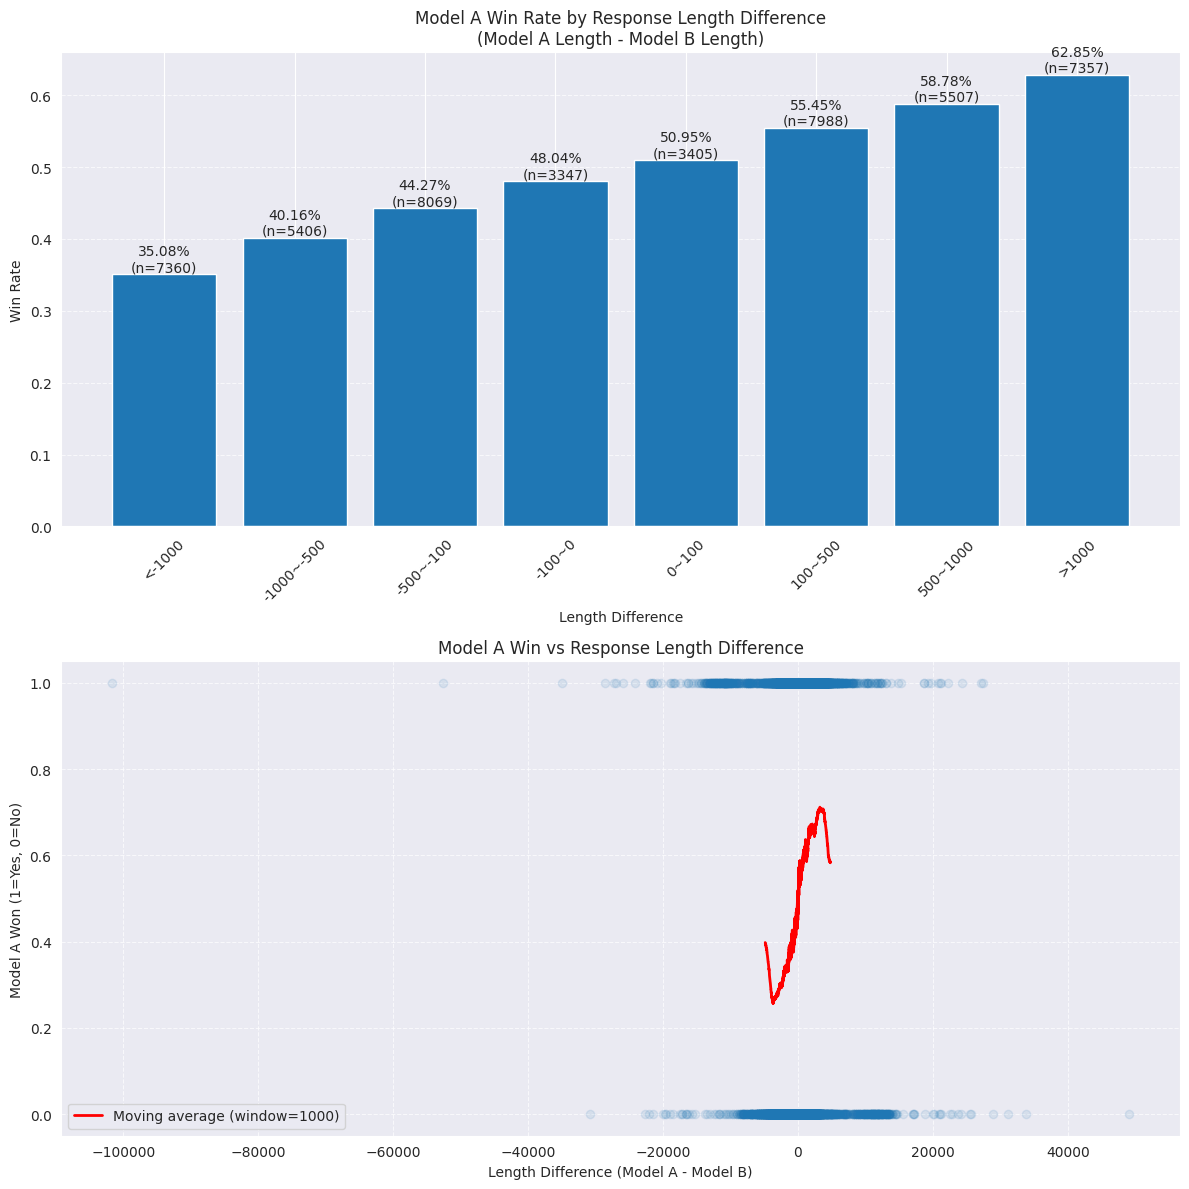


长度差异与胜率的关系：
    长度差异区间  样本数量    胜率
    <-1000  7360 0.351
-1000~-500  5406 0.402
 -500~-100  8069 0.443
    -100~0  3347 0.480
     0~100  3405 0.510
   100~500  7988 0.554
  500~1000  5507 0.588
     >1000  7357 0.629

长度差异与胜率的相关系数: 0.084


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 计算每组回答的长度差异
df_train['response_a_length'] = df_train['response_a'].apply(len)
df_train['response_b_length'] = df_train['response_b'].apply(len)
df_train['length_diff'] = df_train['response_a_length'] - df_train['response_b_length']

# 创建一个新的列，标记model_a是否获胜
df_train['model_a_won'] = (df_train['winner'] == 'model_a').astype(int)

# 将长度差异分组
bins = [-float('inf'), -1000, -500, -100, 0, 100, 500, 1000, float('inf')]
labels = ['<-1000', '-1000~-500', '-500~-100', '-100~0', '0~100', '100~500', '500~1000', '>1000']
df_train['length_diff_group'] = pd.cut(df_train['length_diff'], bins=bins, labels=labels)

# 计算每个长度差异组的胜率
win_rates = df_train.groupby('length_diff_group')['model_a_won'].agg(['count', 'mean']).reset_index()
win_rates.columns = ['length_diff_group', 'count', 'win_rate']

# 创建图表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. 绘制胜率图
bars = ax1.bar(win_rates['length_diff_group'], win_rates['win_rate'])
ax1.set_title('Model A Win Rate by Response Length Difference\n(Model A Length - Model B Length)', fontsize=12)
ax1.set_xlabel('Length Difference', fontsize=10)
ax1.set_ylabel('Win Rate', fontsize=10)
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', rotation=45)

# 在柱子上显示具体胜率和样本数
for bar, count, rate in zip(bars, win_rates['count'], win_rates['win_rate']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{rate:.2%}\n(n={count})',
             ha='center', va='bottom')

# 2. 绘制散点图
ax2.scatter(df_train['length_diff'], df_train['model_a_won'], alpha=0.1)
ax2.set_title('Model A Win vs Response Length Difference', fontsize=12)
ax2.set_xlabel('Length Difference (Model A - Model B)', fontsize=10)
ax2.set_ylabel('Model A Won (1=Yes, 0=No)', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.7)

# 添加移动平均线
window_size = 1000
rolling_mean = df_train.sort_values('length_diff')[['length_diff', 'model_a_won']]\
    .rolling(window=window_size, center=True, on='length_diff')['model_a_won'].mean()
ax2.plot(df_train.sort_values('length_diff')['length_diff'], rolling_mean, 
         color='red', linewidth=2, label=f'Moving average (window={window_size})')
ax2.legend()

plt.tight_layout()
plt.show()

# 打印详细统计信息
print("\n长度差异与胜率的关系：")
stats_df = pd.DataFrame({
    '长度差异区间': win_rates['length_diff_group'],
    '样本数量': win_rates['count'],
    '胜率': win_rates['win_rate'].round(3),
})
print(stats_df.to_string(index=False))

# 计算相关系数
correlation = df_train['length_diff'].corr(df_train['model_a_won'])
print(f"\n长度差异与胜率的相关系数: {correlation:.3f}")

## d) Language distribution
This shows the frequency of different languages in the prompts.

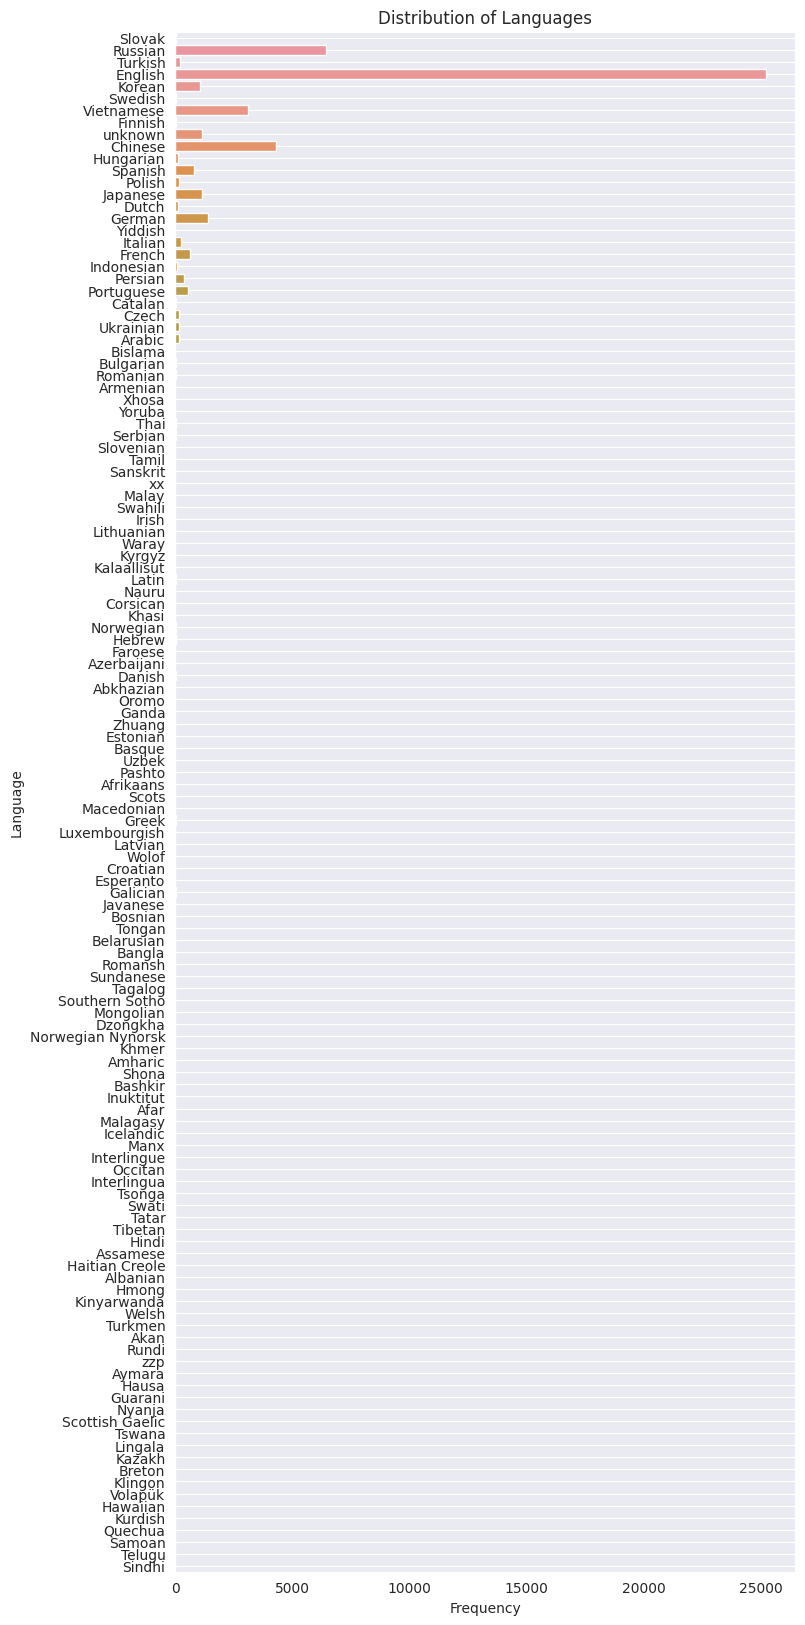

In [43]:
plt.figure(figsize=(8, 20))  # Adjust figure height for better readability
sns.countplot(y='language', data=df_train)
plt.title('Distribution of Languages')
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.grid()
plt.show()

## e) Winner distribution per language
This reveals any potential language-based bias in model performance.

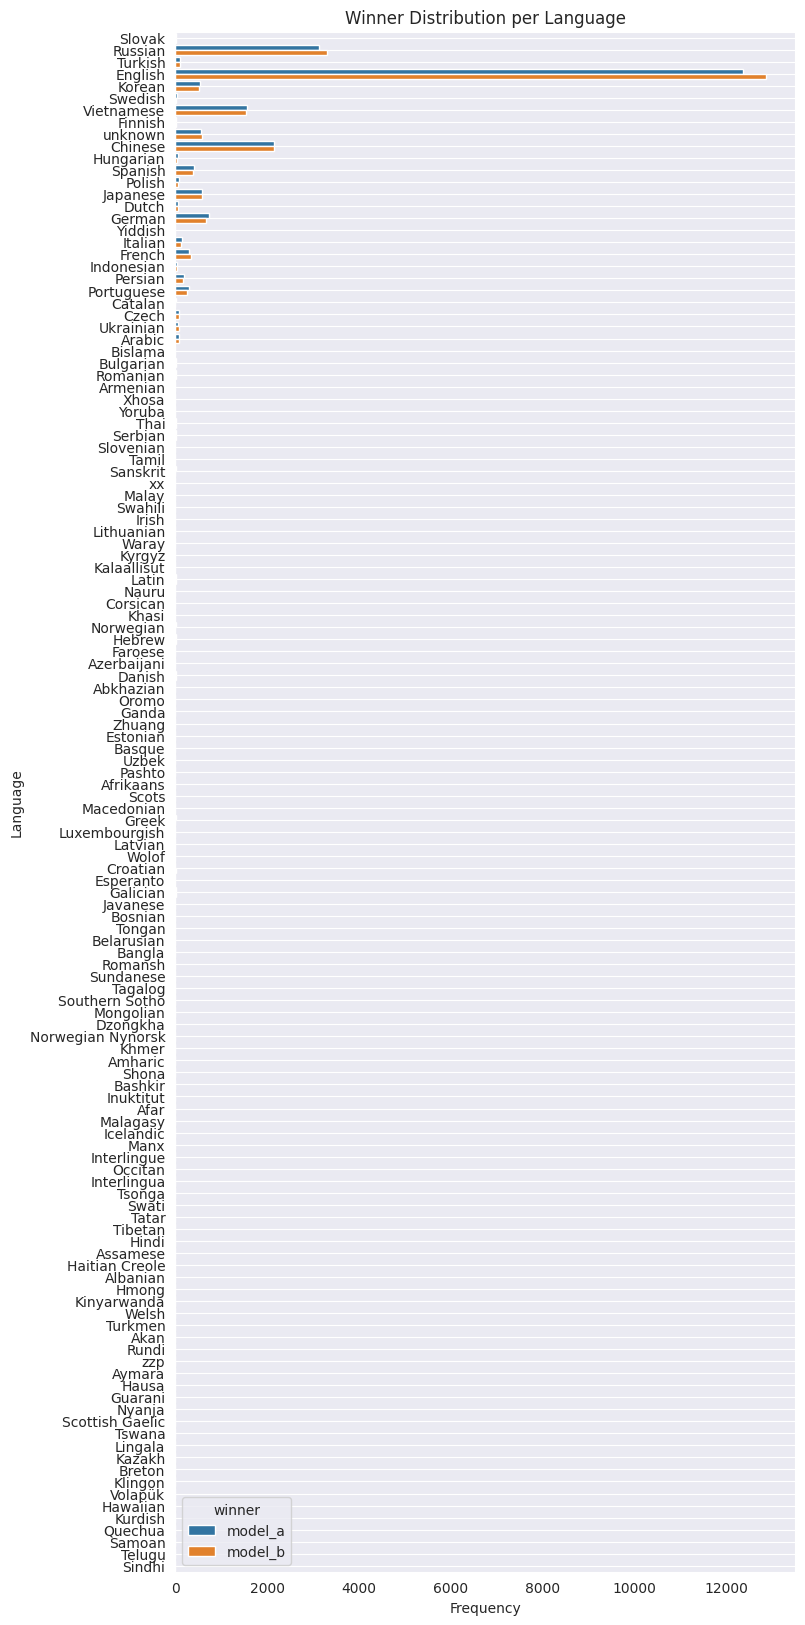

In [44]:
plt.figure(figsize=(8, 20))
sns.countplot(y='language', hue='winner', data=df_train)
plt.title('Winner Distribution per Language')
plt.xlabel('Frequency')
plt.ylabel('Language')
plt.grid()
plt.show()

## f) Prompt and Response Length Correlation
- **Visualization:** Scatter plot with prompt length on the X-axis and response length (for both models A and B) on the Y-axis. Use different colors or markers to represent models A and B.
- **Purpose:** To examine the relationship between prompt length and the length of the generated responses. It can help you understand if longer prompts tend to elicit longer responses, and if this relationship differs between the two models.

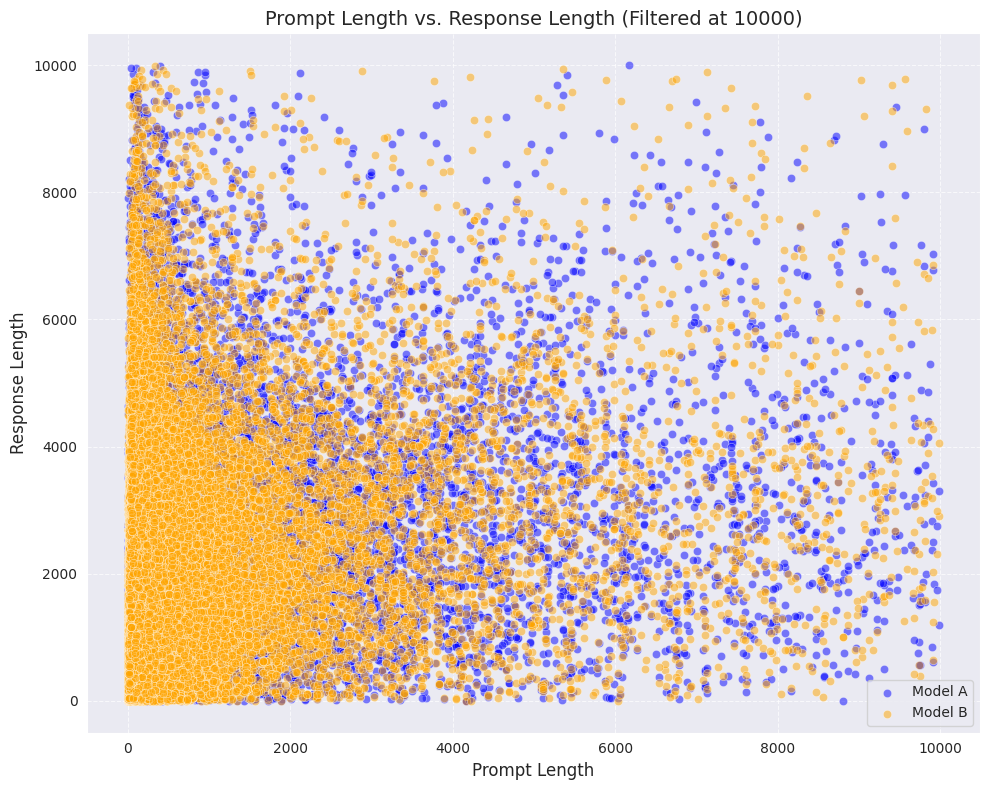

In [46]:
# 过滤掉长度大于10000的例子
filtered_df = df_train[
    (df_train['prompt_length'] <= 10000) & 
    (df_train['response_a_length'] <= 10000) & 
    (df_train['response_b_length'] <= 10000)
]

# 绘制更精细的散点图
plt.figure(figsize=(10, 8))

sns.scatterplot(
    x='prompt_length', y='response_a_length', 
    data=filtered_df, label='Model A', alpha=0.5, color='blue'
)
sns.scatterplot(
    x='prompt_length', y='response_b_length', 
    data=filtered_df, label='Model B', alpha=0.5, color='orange'
)

plt.title('Prompt Length vs. Response Length (Filtered at 10000)', fontsize=14)
plt.xlabel('Prompt Length', fontsize=12)
plt.ylabel('Response Length', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [48]:
# 计算长度
df_train['prompt_length'] = df_train['prompt'].apply(len)
df_train['response_a_length'] = df_train['response_a'].apply(len)
df_train['response_b_length'] = df_train['response_b'].apply(len)

# 定义统计函数
def count_lengths_and_ratio(df, max_length):
    filtered_df = df[
        (df['prompt_length'] <= max_length) & 
        (df['response_a_length'] <= max_length) & 
        (df['response_b_length'] <= max_length)
    ]
    count = len(filtered_df)
    ratio = count / len(df) * 100  # 计算占比
    return count, round(ratio, 2)

# 统计同时满足条件的数量和占比
count_3000, ratio_3000 = count_lengths_and_ratio(df_train, 3000)
count_3500, ratio_3500 = count_lengths_and_ratio(df_train, 3500)
count_4000, ratio_4000 = count_lengths_and_ratio(df_train, 4000)

# 打印统计结果
print(f"同时小于等于 3000 的数量: {count_3000}, 占比: {ratio_3000}%")
print(f"同时小于等于 3500 的数量: {count_3500}, 占比: {ratio_3500}%")
print(f"同时小于等于 4000 的数量: {count_4000}, 占比: {ratio_4000}%")

同时小于等于 3000 的数量: 32347, 占比: 66.78%
同时小于等于 3500 的数量: 36441, 占比: 75.23%
同时小于等于 4000 的数量: 39471, 占比: 81.49%


## g) Winner Distribution by Model Identity
- **Visualization:** A bar chart showing the win rate for each distinct model (model_a and model_b).
- **Purpose:** To compare the overall performance of the different models used in the competition. It can identify which models tend to perform better overall.

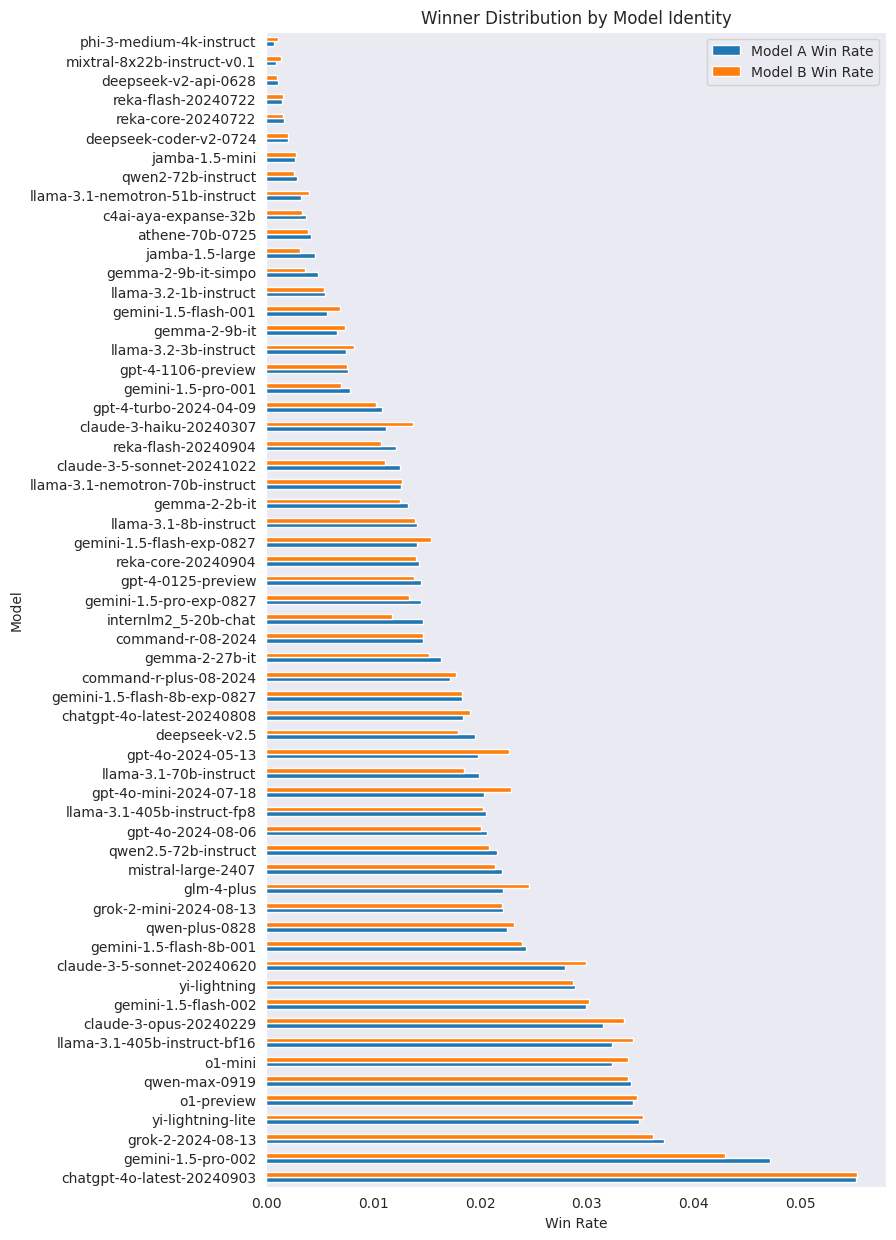

In [49]:
model_a_win_rate = df_train[df_train['winner'] == 'model_a']['model_a'].value_counts(normalize=True)
model_b_win_rate = df_train[df_train['winner'] == 'model_b']['model_b'].value_counts(normalize=True)

win_rates = pd.concat([model_a_win_rate, model_b_win_rate], axis=1)
win_rates.columns = ['Model A Win Rate', 'Model B Win Rate']

win_rates.plot(kind='barh', figsize=(8, 15))
plt.title('Winner Distribution by Model Identity')
plt.ylabel('Model')
plt.xlabel('Win Rate')
plt.grid()
plt.show()

## h) Cross-Comparison Win Rate Heatmap (Between models)
The heatmap represents the win rate of Model A against Model B.

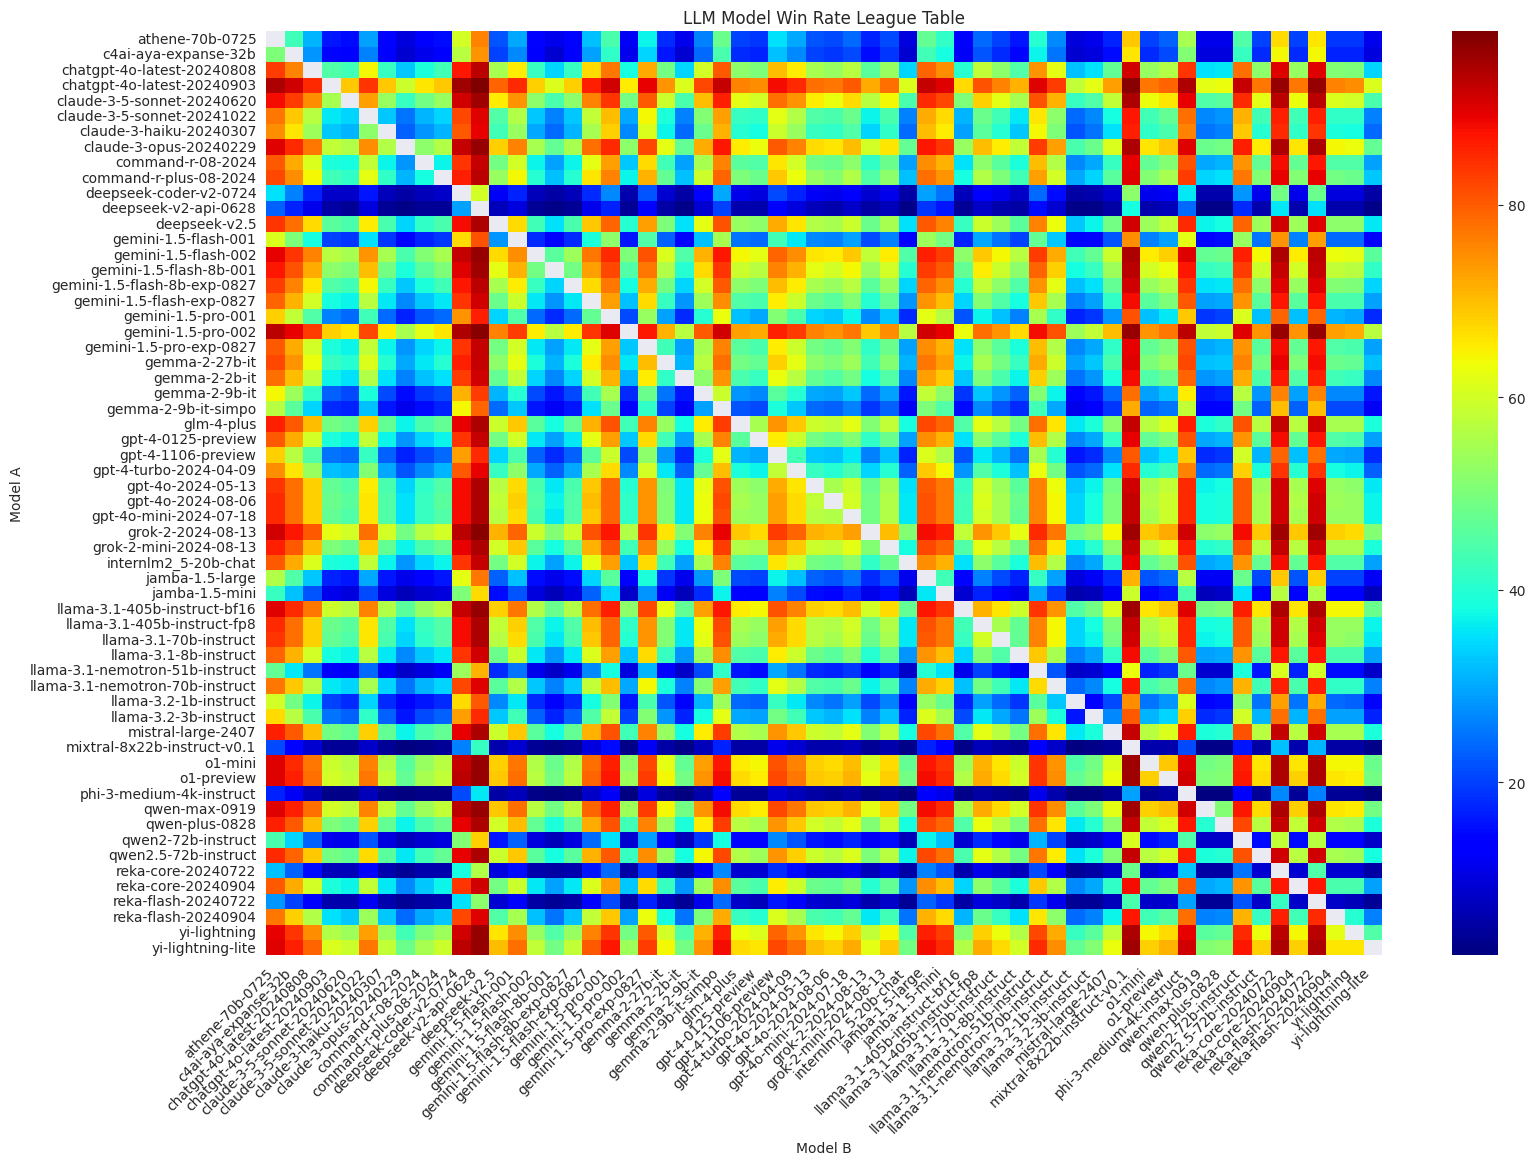

In [50]:
# Create a cross-tabulation of models and winners
model_wins = pd.crosstab(df_train['model_a'], df_train['winner'])  # Using model_a as a reference

# Get unique models
models = model_wins.index.tolist()

# Create a league table DataFrame
league_table = pd.DataFrame(index=models, columns=models)

# Calculate and fill the league table with win rates
for model1 in models:
    for model2 in models:
        if model1 == model2:
            league_table.loc[model1, model2] = '-'  # Diagonal (model vs. itself)
        else:
            # Calculate win rate of model1 against model2
            try:
                wins_model1 = model_wins.loc[model1, 'model_a']  # Wins of model1
                wins_model2 = model_wins.loc[model2, 'model_b']  # Assuming model_b represents wins of model2
                total_matches = wins_model1 + wins_model2
                win_rate = (wins_model1 / total_matches) * 100 if total_matches else 0
                
            except KeyError:
              win_rate = 0
                
            league_table.loc[model1, model2] = f'{win_rate:.0f}%'  # Format win rate

# Remove percentage signs and convert to numeric
league_table_numeric = league_table.apply(lambda x: pd.to_numeric(x.str.rstrip('%'), errors='coerce'))

# Replace hyphens with np.nan (if they still exist)
league_table_numeric = league_table_numeric.replace('-', np.nan)

# Display the league table using seaborn heatmap with colorbar
plt.figure(figsize=(18, 12))
heatmap = sns.heatmap(league_table_numeric, cmap='jet', cbar=True, xticklabels=True, yticklabels=True)
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')
#sns.heatmap(league_table_numeric, cmap='jet', cbar=True)  # Removed annot and fmt, added cbar=True
plt.title('LLM Model Win Rate League Table')
plt.xlabel('Model B')
plt.ylabel('Model A')
plt.grid()
plt.show()